In [1]:
import numpy as np

# Same here
navs = ('No navegable', 'Navegable')

x = np.load('processed_nav_data.npy')
y = np.load('nav_data_labels.npy')

x_train, x_val, x_test = np.split(
    np.array(x), [int(len(x)*0.7), int(len(x)*0.85)])
y_train, y_val, y_test = np.split(
    np.array(y), [int(len(y)*0.7), int(len(y)*0.85)])

n_clases = len(navs)
n_features = len(x[0])

print(np.unique(y, return_counts=True))
print(len(x))
print(len(y))
print(n_clases)
print(n_features)

2021-11-13 18:05:52.022348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(array([0, 1]), array([361, 759]))
1120
1120
2
10


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import backend

# We want to make sure we start from the start when training our model everytime we run it.
backend.clear_session()

# Define MLP model
model = Sequential()
model.add(Dense(512, input_dim=n_features, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2021-11-13 18:05:53.318324: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-13 18:05:53.327415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-13 18:05:53.776613: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-13 18:05:53.776653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.215GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2021-11-13 18:05:53.776683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-13 18:05:53.777896: I tensorflow/stre

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 531,457
Trainable params: 531,457
Non-trainable params: 0
_________________________________________________________________


In [4]:
from keras import optimizers

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.96)
opt = optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',
              optimizer=opt, metrics=['accuracy'])

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('nav_best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)
# Fit model
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y)
print(class_weights)

[1.55124654 0.73781291]


/home/hivini/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [6]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), class_weight=(
    dict(zip(np.unique(y), class_weights))), epochs=150, batch_size=1, callbacks=[es, mc])

2021-11-13 18:05:55.684079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-13 18:05:55.684447: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2208005000 Hz


Epoch 1/150


2021-11-13 18:05:56.034566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


784/784 [==============================] - 5s 5ms/step - loss: 0.6422 - accuracy: 0.4030 - val_loss: 0.6910 - val_accuracy: 0.5417

Epoch 00001: val_accuracy improved from -inf to 0.54167, saving model to nav_best_model.h5
Epoch 2/150
784/784 [==============================] - 4s 6ms/step - loss: 0.5333 - accuracy: 0.7087 - val_loss: 0.6536 - val_accuracy: 0.6310

Epoch 00002: val_accuracy improved from 0.54167 to 0.63095, saving model to nav_best_model.h5
Epoch 3/150
784/784 [==============================] - 4s 5ms/step - loss: 0.4928 - accuracy: 0.8091 - val_loss: 0.6205 - val_accuracy: 0.6667

Epoch 00003: val_accuracy improved from 0.63095 to 0.66667, saving model to nav_best_model.h5
Epoch 4/150
784/784 [==============================] - 4s 6ms/step - loss: 0.4979 - accuracy: 0.7985 - val_loss: 0.6641 - val_accuracy: 0.6726

Epoch 00004: val_accuracy improved from 0.66667 to 0.67262, saving model to nav_best_model.h5
Epoch 5/150
784/784 [==============================] - 4s 5ms/s

In [7]:
from tensorflow import keras

model = keras.models.load_model('nav_best_model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)

6/6 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6667
Loss on test set:  0.6662001609802246
Accuracy on test set:  0.6666666865348816


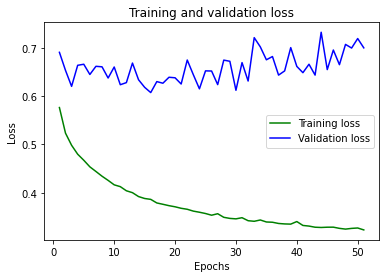

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# bo is for blue dot.
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


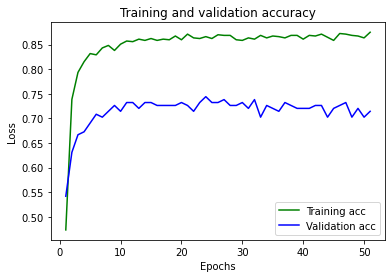

In [9]:
plt.clf()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
